In [80]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../../XRaySimulation2")

from XRaySimulation import util
import scipy.signal as sps

import matplotlib
from matplotlib.colors import LogNorm

matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 14

# Explanation
The illumination volume is contains in a region of 
20 um x 40 um x 100 um  (x, y, z)
Therefore, I can create a box with resolution of 1um along each axis
Then, I will calculate if this pixel is illuminated.
Then, I will calculate along the z axis, how many TG periods are in the illumination volume
Then, I'll calculate the mean TG period number

In [81]:
def add_weight_cylinder(start, direction, fwhm_xy, space, attenuation_length_um, surface_point, surface_normal,
                        beam_attenaution=False):
    # Get the distance
    l_pixel = (space - surface_point[np.newaxis, np.newaxis, np.newaxis, :])
    l_pixel = np.dot(l_pixel, surface_normal)
    l_pixel /= np.dot(direction, surface_normal)

    # Get a mask such that we only keep the pixel inside the surface
    sample_mask = (l_pixel >= 0)

    # Get a mask that only consider space inside the cylinder
    displacement = (space - start[np.newaxis, np.newaxis, np.newaxis, :])
    deviation = displacement - np.multiply(np.dot(displacement, direction)[:, :, :, np.newaxis],
                                           direction[np.newaxis, np.newaxis, np.newaxis, :])
    displacement_x = deviation[:, :, :, 0]
    displacement_yz = np.sqrt(deviation[:, :, :, 1] ** 2 + deviation[:, :, :, 2] ** 2)

    # Check if the pixel is within the volume of illumination
    x_ray_mask = (displacement_x ** 2 / fwhm_xy[0] ** 2 + displacement_yz ** 2 / fwhm_xy[1] ** 2 - 1 <= 0)
    total_mask = np.multiply(sample_mask, x_ray_mask)

    # Add the weight according to the attenuation coefficient
    weight = np.zeros_like(displacement_x, dtype=np.float64)
    weight[total_mask] = np.exp(-l_pixel[total_mask] / attenuation_length_um)

    if beam_attenaution:
        print("Get get the weight assuming a Gaussian X-ray profile")
        sigma_x = util.fwhm_to_sigma(fwhm=fwhm_xy[0])
        sigma_y = util.fwhm_to_sigma(fwhm=fwhm_xy[1])

        weight *= np.exp(- displacement_x ** 2 / sigma_x ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_x
        weight *= np.exp(- displacement_yz ** 2 / sigma_y ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_y

    else:
        print("Get get the weight assuming a flat X-ray profile")

    return weight

In [82]:
#kin = np.array([-1398.73758358, -19381.33420562, 45704.44855449])
kin = np.array([-0.11689482, -1.97294018, 4.55617549]) * 1e4
kin_direction = kin / np.linalg.norm(kin)

tilt_angle = np.deg2rad(11.5)
surface_normal = np.array([-np.cos(tilt_angle), 0, np.sin(tilt_angle)])

beam_size_x = 5.  # um
beam_size_y = 10.  # um
coh_length = 10 * util.c  # um

# Get the sigma
beam_sigma_x = util.intensity_fwhm_to_field_sigma(fwhm=beam_size_x)
beam_sigma_y = util.intensity_fwhm_to_field_sigma(fwhm=beam_size_y)
beam_sigma_z = util.intensity_fwhm_to_field_sigma(fwhm=coh_length)

nx = 256
ny = 64
nz = 256 * 2

dx = 11.8 / 100 / 2
dy = 3. / 4
dz = 0.5 / 6

volume = np.zeros((nx, ny, nz, 3))
volume[:, :, :, 0] = np.linspace(-nx * dx / 2, nx * dx / 2, num=nx)[:, np.newaxis, np.newaxis]
volume[:, :, :, 1] = np.linspace(-ny * dy / 2, ny * dy / 2, num=ny)[np.newaxis, :, np.newaxis]
volume[:, :, :, 2] = np.linspace(-nz * dz / 2, nz * dz / 2, num=nz)[np.newaxis, np.newaxis, :]

In [83]:
# Get the total weight
weight_pulse1 = add_weight_cylinder(start=np.array([-0., 0., 0.]),
                                    direction=np.array([np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., 0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse2 = add_weight_cylinder(start=np.array([0., -0., 0.]),
                                    direction=np.array([-np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., 0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse3 = add_weight_cylinder(start=np.array([0., 0., 0.]),
                                    direction=kin_direction,
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., -0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse1[weight_pulse1 < np.max(weight_pulse1) * 1e-6] = 0.
weight_pulse2[weight_pulse2 < np.max(weight_pulse2) * 1e-6] = 0.
weight_pulse3[weight_pulse3 < np.max(weight_pulse3) * 1e-6] = 0.

pump_weight = weight_pulse1 + weight_pulse2
probe_weight = weight_pulse3

total_weight = probe_weight + pump_weight
del volume

Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile


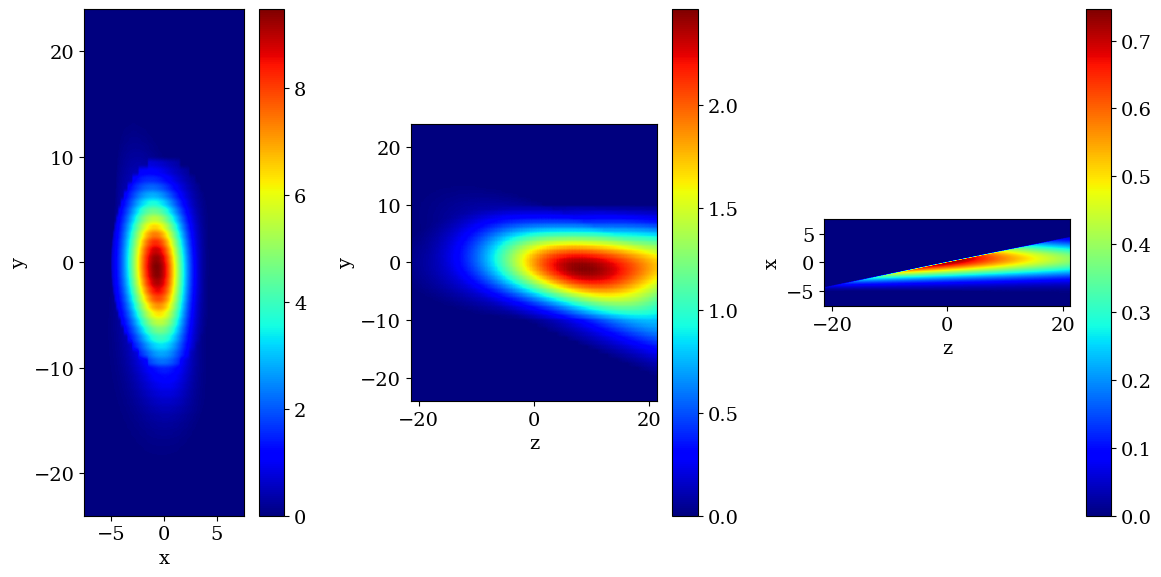

In [84]:
weight_xy = np.sum(total_weight, axis=-1)
weight_xz = np.sum(total_weight, axis=1)
weight_yz = np.sum(total_weight, axis=0)

fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(6)
fig.set_figwidth(12)
im1 = axes[0].imshow(weight_xy.T, extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                     origin='lower')
#im1 = axes[0].imshow(weight_xy.T, cmap='jet')
fig.colorbar(im1, ax=axes[0])
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

im2 = axes[1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                     origin='lower')
#im2 = axes[1].imshow(weight_yz, cmap='jet')
fig.colorbar(im2, ax=axes[1])
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

im3 = axes[2].imshow(weight_xz, extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet',
                     origin='lower')
#im3 = axes[2].imshow(weight_xz, cmap='jet')
fig.colorbar(im3, ax=axes[2])
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

In [85]:
# Get the scattering volume
scatter_volume = np.multiply(weight_pulse1 + weight_pulse2, weight_pulse3)
scatter_volume[weight_pulse1 > 100 * weight_pulse2] = 0
scatter_volume[weight_pulse2 > 100 * weight_pulse1] = 0
scatter_volume[weight_pulse3 < 1e-3 * np.max(weight_pulse3)] = 0

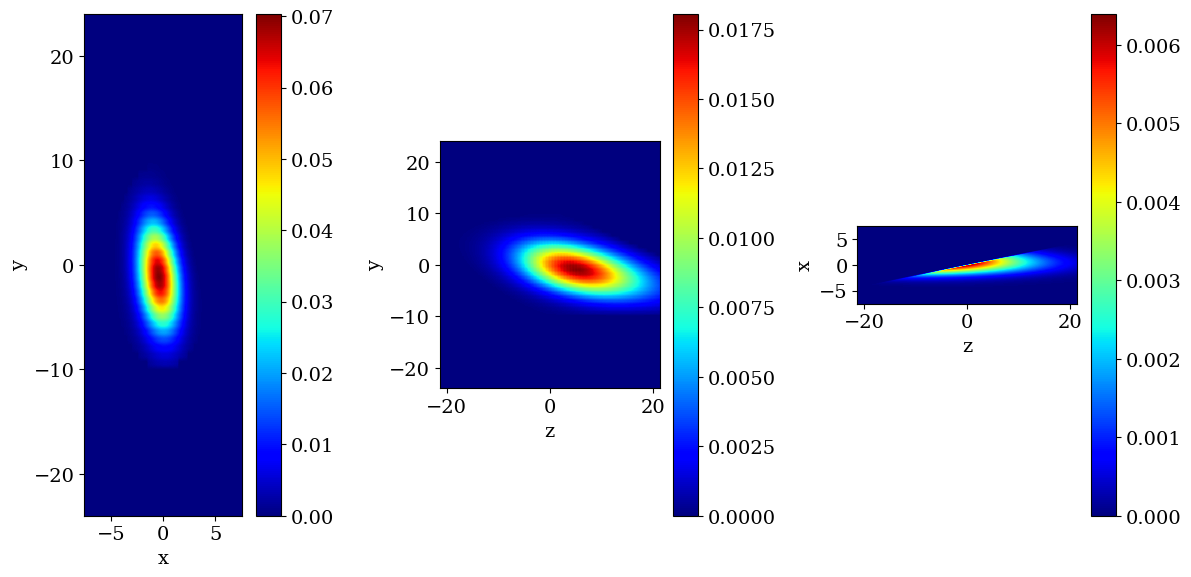

In [86]:
weight_xy = np.sum(scatter_volume, axis=-1)
weight_xz = np.sum(scatter_volume, axis=1)
weight_yz = np.sum(scatter_volume, axis=0)

fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(6)
fig.set_figwidth(12)
im1 = axes[0].imshow(weight_xy.T, extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                     origin='lower')
fig.colorbar(im1, ax=axes[0])
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

im2 = axes[1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                     origin='lower')
fig.colorbar(im2, ax=axes[1])
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

im3 = axes[2].imshow(weight_xz, extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet',
                     origin='lower')
fig.colorbar(im3, ax=axes[2])
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

In [87]:
## Get the volume assuming full coherence
volume_fft = np.square(np.abs(np.fft.fftshift(np.fft.fftn(scatter_volume))))

kx = np.fft.fftshift(np.fft.fftfreq(n=nx, d=dx)) * np.pi * 2  #/ 1e4
ky = np.fft.fftshift(np.fft.fftfreq(n=ny, d=dy)) * np.pi * 2  #/ 1e4
kz = np.fft.fftshift(np.fft.fftfreq(n=nz, d=dz)) * np.pi * 2  #/ 1e4

In [88]:
g_vec = np.array([3.11361484, 3.2118638, -0.83751243]) * 1e4  # um^-1
g_dir = g_vec / np.linalg.norm(g_vec)
n_dir1 = np.array([g_vec[1], -g_vec[0], 0.])
n_dir1 /= np.linalg.norm(n_dir1)
n_dir2 = np.cross(g_dir, n_dir1)
n_dir2 /= np.linalg.norm(n_dir2)

# I would like to know what is the difference if there is a 5 mdeg angular difference
max_delta = np.linalg.norm(g_vec) * np.sin(np.deg2rad(3.7e-3))
# Therefore, one needs to consider the Q smearing along the normal direction of the g_vec
# Construct the Q average mask
q_vol = np.zeros((nx, ny, nz, 3))
q_vol[:, :, :, 0] = kx[:, np.newaxis, np.newaxis]
q_vol[:, :, :, 1] = ky[np.newaxis, :, np.newaxis]
q_vol[:, :, :, 2] = kz[np.newaxis, np.newaxis, :]

sigma_g_p = 0.1  # um
sigma_g_n = util.fwhm_to_sigma(2 * max_delta)  # um

q_weight = np.exp(- 0.5 * (np.dot(q_vol, g_dir) ** 2 / sigma_g_p ** 2 +
                           np.dot(q_vol, n_dir1) ** 2 / sigma_g_n ** 2 +
                           np.dot(q_vol, n_dir2) ** 2 / sigma_g_n ** 2))

q_weight /= np.sum(q_weight)

In [89]:
### Get the total volume
volume_total = sps.fftconvolve(volume_fft, q_weight, mode='same')

### Get the projection
proj_yz = np.sum(volume_total, axis=0)
proj_xz = np.sum(volume_total, axis=1)
proj_xy = np.sum(volume_total, axis=2)

In [90]:
# Get the wave-vectors
angle_num = 1000
angle_list = np.linspace(start=-np.deg2rad(0.05), stop=np.deg2rad(0.05), num=angle_num)

fit_x = np.array([6.40342603e-01, 5.06962809e-09]) * 1e4
fit_y = np.array([1.99944147e-01, -4.08478486e-07]) * 1e4
fit_z = np.array([3.14738445e+00, 2.49180183e-08]) * 1e4

fit_qx = angle_list * fit_x[0] + fit_x[1]
fit_qy = angle_list * fit_y[0] + fit_y[1]
fit_qz = angle_list * fit_z[0] + fit_z[1]

q_list = np.zeros((angle_num, 3))
q_list[:, 0] = fit_qx
q_list[:, 1] = fit_qy
q_list[:, 2] = fit_qz

from scipy.interpolate import RegularGridInterpolator

interp = RegularGridInterpolator((kx, ky, kz), volume_total, bounds_error=False, fill_value=None)
rock = interp(q_list)


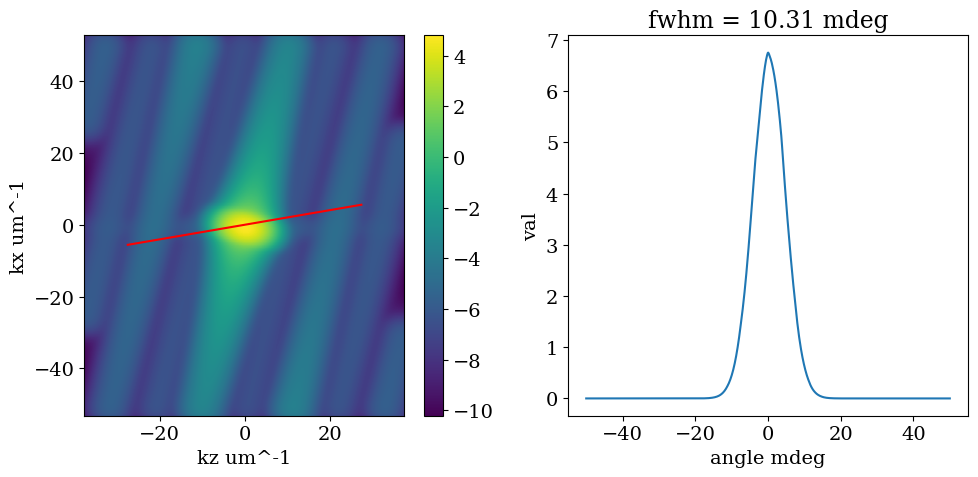

In [91]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

#img1 = axes[0].imshow(np.log(proj_xz), vmax=-16, vmin=-25, extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto')
img1 = axes[0].imshow(np.log(proj_xz), extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto')
fig.colorbar(img1, ax=axes[0])
axes[0].plot(fit_qz, fit_qx, c='r')
axes[0].set_xlabel("kz um^-1")
axes[0].set_ylabel("kx um^-1")

axes[1].plot(np.rad2deg(angle_list) * 1e3, rock)
axes[1].set_xlabel("angle mdeg")
axes[1].set_ylabel("val")
fwhm = util.get_fwhm(coordinate=np.rad2deg(angle_list) * 1e3, curve_values=rock)
axes[1].set_title("fwhm = {:.2f} mdeg".format(fwhm))

plt.tight_layout()
plt.savefig("rocking_fit.png", dpi=300, bbox_inches='tight')
plt.show()

In [92]:
### Get the total volume
volume_total = np.copy(volume_fft)

### Get the projection
proj_yz_perfect = np.sum(volume_total, axis=0)
proj_xz_perfect = np.sum(volume_total, axis=1)
proj_xy_perfect = np.sum(volume_total, axis=2)

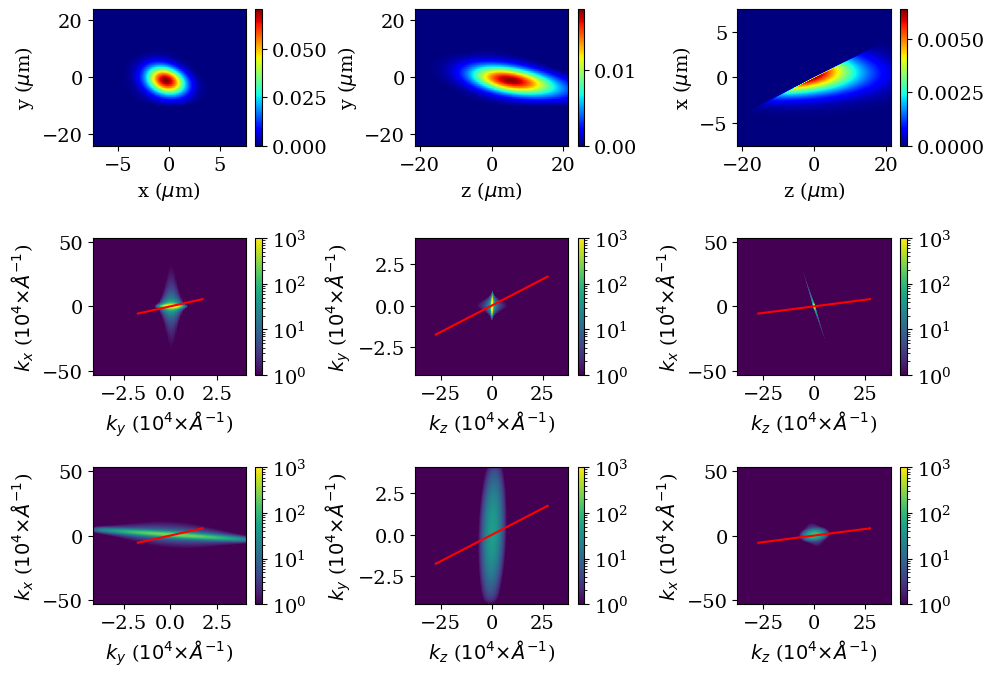

In [96]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(10, 12))

# TODO: Convert the color map to the average total flux
# The first row shows the projection of the illumination volume
im1 = axes[0, 0].imshow(weight_xy.T, extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                        origin='lower', aspect='auto')
fig.colorbar(im1, ax=axes[0, 0])
axes[0, 0].set_xlabel("x ($\mu$m)")
axes[0, 0].set_ylabel("y ($\mu$m)")

im2 = axes[0, 1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                        origin='lower', aspect='auto')
fig.colorbar(im2, ax=axes[0, 1])
axes[0, 1].set_xlabel("z ($\mu$m)")
axes[0, 1].set_ylabel("y ($\mu$m)")

im3 = axes[0, 2].imshow(weight_xz, extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet',
                        origin='lower', aspect='auto')
fig.colorbar(im3, ax=axes[0, 2])
axes[0, 2].set_xlabel("z ($\mu$m)")
axes[0, 2].set_ylabel("x ($\mu$m)")

# The third row shows the projection of the reciprocal space
vmin = 1
vmax = 1e3
img1 = axes[1, 0].imshow(np.abs(proj_xy_perfect), extent=[ky[0], ky[-1], kx[0], kx[-1]], aspect='auto', origin='lower',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(img1, ax=axes[1, 0])
axes[1, 0].plot(fit_qy, fit_qx, c='r')
axes[1, 0].set_xlabel(r"$k_y$ ($10^4$$\times$$\AA^{-1}$)")
axes[1, 0].set_ylabel(r"$k_x$ ($10^4$$\times$$\AA^{-1}$)")

img2 = axes[1, 1].imshow(np.abs(proj_yz_perfect), extent=[kz[0], kz[-1], ky[0], ky[-1]], aspect='auto', origin='lower',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(img2, ax=axes[1, 1])
axes[1, 1].plot(fit_qz, fit_qy, c='r')
axes[1, 1].set_xlabel(r"$k_z$ ($10^4$$\times$$\AA^{-1}$)")
axes[1, 1].set_ylabel(r"$k_y$ ($10^4$$\times$$\AA^{-1}$)")

img3 = axes[1, 2].imshow(np.abs(proj_xz_perfect), extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto', origin='lower',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(img3, ax=axes[1, 2])
axes[1, 2].plot(fit_qz, fit_qx, c='r')
axes[1, 2].set_xlabel(r"$k_z$ ($10^4$$\times$$\AA^{-1}$)")
axes[1, 2].set_ylabel(r"$k_x$ ($10^4$$\times$$\AA^{-1}$)")

# The second row shows the projection of the reciprocal space
img1 = axes[2, 0].imshow(np.abs(proj_xy), extent=[ky[0], ky[-1], kx[0], kx[-1]], aspect='auto', origin='lower',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(img1, ax=axes[2, 0])
axes[2, 0].plot(fit_qy, fit_qx, c='r')
axes[2, 0].set_xlabel(r"$k_y$ ($10^4$$\times$$\AA^{-1}$)")
axes[2, 0].set_ylabel(r"$k_x$ ($10^4$$\times$$\AA^{-1}$)")

img2 = axes[2, 1].imshow(np.abs(proj_yz), extent=[kz[0], kz[-1], ky[0], ky[-1]], aspect='auto', origin='lower',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(img2, ax=axes[2, 1])
axes[2, 1].plot(fit_qz, fit_qy, c='r')
axes[2, 1].set_xlabel(r"$k_z$ ($10^4$$\times$$\AA^{-1}$)")
axes[2, 1].set_ylabel(r"$k_y$ ($10^4$$\times$$\AA^{-1}$)")

img3 = axes[2, 2].imshow(np.abs(proj_xz), extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto', origin='lower',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(img3, ax=axes[2, 2])
axes[2, 2].plot(fit_qz, fit_qx, c='r')
axes[2, 2].set_xlabel(r"$k_z$ ($10^4$$\times$$\AA^{-1}$)")
axes[2, 2].set_ylabel(r"$k_x$ ($10^4$$\times$$\AA^{-1}$)")


# The 4th row shows the rocking curve



plt.tight_layout()
#plt.savefig("rocking_fit.png", dpi=300, bbox_inches='tight')
plt.show()